In [1]:
# Lab 3.8 - Logistic Regression: Making Predictions

# Workflow

#### Understanding the problem  
Predict if a film will have more monthly rentals in July than in June. Use data from 2005.  
Create a column that shows if the number or rentals is higher in July than in June.

1. Setting expectations: 
    1. Choose the appropriate features from film and rentals:
        * Film:
            + film_id
            + ? description? --> find the most repeated words in the rented films?
            + ~~release_year~~
            + ~~language_id~~ there is only one value
            + rental_duration
            + rental_rate --> with rental_duration determines the daily cost --> GET DAILY COST
            + length
            + rating --> ranked
            + replacement_cost --> it means the cost of the material copy
            + ~~calcular los costes agredados al alquiler~~ --> would need to consider payment also
            + ~~special_features --> split the features~~ I think it is completely meaningless
        * Rental:
            + rental_id --> ~~get the copies (there's no need to get the store)~~== n_customers
            + number of rentals by film, store and month
            + rental_date
            + return_date --> get the real rental duration and compare with film variable ?
            + average duration or rent_period --> separate table
            + customer_id --> get the number of customers that rented the film
            + ~~staff_id~~ --> is redundant to have the store and the staff id? YES
        * Inventory:
            + Inventory_id --> get the number of copies of every film by store/staff: copies 1 n 2 or copies-staff
        * Actor:
            + Actor --> Rank the top rented actors in July?; Get the actors for every movie?
        * Category:
            + Category_id  --> rank the most rented categories in july

In [2]:
# Now the problem is understood, do not beat around the bush with the queries and finish as soon as possible

"""
Point 1:
Anyway... The summary of tables:

General table

Top rented categories
Number of super stars

Ranking ratings --> ordinal category

Rental period



Point 2:

Total amount of rentals in June
Total amount of rentals in July

Create a new column


"""



'\nPoint 1:\nAnyway... The summary of tables:\n\nGeneral table\n\nTop rented categories\nNumber of super stars\n\nRanking ratings --> ordinal category\n\nRental period\n\n\n\nPoint 2:\n\nTotal amount of rentals in June\nTotal amount of rentals in July\n\nCreate a new column\n\n\n'

# Import Libraries

In [161]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.preprocessing import PowerTransformer


In [4]:
%matplotlib inline

In [5]:
from pandas.api.types import CategoricalDtype

# Connect to SQL server and get the data

In [6]:
password = getpass.getpass()

········


In [7]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [8]:
main_query = '''\
select film_id, round(rental_rate/rental_duration,2) as daily_cost, length
		, rating, replacement_cost
        , count(customer_id) as n_customers
from film
join inventory
using(film_id)
join rental
using(inventory_id)
where year(rental_date) = 2005 -- and month(rental_date) = 7 
group by film_id; 
'''

#data = pd.read_sql_query(query, engine)
#data.head()

In [9]:
film = pd.read_sql_query(main_query, engine)
film.head()

,film_id,daily_cost,length,rating,replacement_cost,n_customers
0,1,0.17,86,PG,20.99,23
1,2,1.66,48,G,12.99,6
2,3,0.43,50,NC-17,18.99,12
3,4,0.60,117,G,26.99,22
4,5,0.50,130,G,22.99,11


## get descriptive data of the films

In [10]:
category_query = """\
select film_id, category_id as top_categories from film_category
where category_id in (15,2,1,7,14);
"""

stars_query = """\
select film_id, count(actor_id) as n_stars from film_actor
where actor_id in (107,181,198,144,60) -- if I place a subquery must contain with having instead of limit
group by film_id;
"""

rating_query = """\
select rating, count(rental_id) as n_rents from film
join inventory
using(film_id)
join rental
using(inventory_id)
where year(rental_date) = 2005
group by rating
order by n_rents desc;
"""

period_query = """\
select film_id, round(avg(datediff(return_date, rental_date)),0) as rent_period
from film
join inventory
using(film_id)
join rental
using(inventory_id)
where return_date is not null
group by film_id;
"""

In [11]:
top_categories = pd.read_sql_query(category_query, engine)
top_categories.head() # --> ordinal category; find the rank in the query

,film_id,top_categories
0,19,1
1,21,1
2,29,1
3,38,1
4,56,1


In [12]:
top_stars = pd.read_sql_query(stars_query, engine)
top_stars.head() # --> numerical

,film_id,n_stars
0,31,1
1,85,1
2,133,2
3,142,1
4,177,1


In [13]:
rating = pd.read_sql_query(rating_query, engine)
rating.head() # --> ordinal

,rating,n_rents
0,PG-13,3543
1,NC-17,3249
2,PG,3178
3,R,3152
4,G,2740


In [14]:
periods = pd.read_sql_query(period_query, engine)
periods.head() 

,film_id,rent_period
0,1,5.0
1,2,6.0
2,3,3.0
3,4,5.0
4,5,7.0


## get the rentals data

In [15]:
june_query = """\
select film_id, count(rental_id) as n_rents 
from film
join inventory
using(film_id)
join rental
using(inventory_id)
where year(rental_date) = 2005 and month(rental_date) = 6 
group by film_id;
"""

july_query = """\
select film_id, count(rental_id) as n_rents 
from film
join inventory
using(film_id)
join rental
using(inventory_id)
where year(rental_date) = 2005 and month(rental_date) = 7 
group by film_id;
"""


In [16]:
june = pd.read_sql_query(june_query, engine)
june.head() 

,film_id,n_rents
0,1,3
1,3,1
2,4,2
3,5,2
4,6,3


In [17]:
july = pd.read_sql_query(july_query, engine)
july.head() 

,film_id,n_rents
0,1,9
1,2,2
2,3,4
3,4,12
4,5,5


## perform joins

### Top Categories --> Ordinal

In [18]:
film = film.merge(top_categories, how='left', on= 'film_id')
film.head()

,film_id,daily_cost,length,rating,replacement_cost,n_customers,top_categories
0,1,0.17,86,PG,20.99,23,NaN
1,2,1.66,48,G,12.99,6,NaN
2,3,0.43,50,NC-17,18.99,12,NaN
3,4,0.60,117,G,26.99,22,NaN
4,5,0.50,130,G,22.99,11,NaN


In [19]:
film.isna().sum()

film_id               0
daily_cost            0
length                0
rating                0
replacement_cost      0
n_customers           0
top_categories      640
dtype: int64

In [20]:
film.shape

(958, 7)

In [21]:
film.top_categories.fillna(0, inplace = True)
film.head()

,film_id,daily_cost,length,rating,replacement_cost,n_customers,top_categories
0,1,0.17,86,PG,20.99,23,0.0
1,2,1.66,48,G,12.99,6,0.0
2,3,0.43,50,NC-17,18.99,12,0.0
3,4,0.60,117,G,26.99,22,0.0
4,5,0.50,130,G,22.99,11,0.0


In [22]:
film.dtypes

film_id               int64
daily_cost          float64
length                int64
rating               object
replacement_cost    float64
n_customers           int64
top_categories      float64
dtype: object

In [23]:
film.top_categories = film.top_categories.astype('object')

In [24]:
film.dtypes

film_id               int64
daily_cost          float64
length                int64
rating               object
replacement_cost    float64
n_customers           int64
top_categories       object
dtype: object

### Top stars --> Numerical

In [25]:
film = film.merge(top_stars, how='left', on= 'film_id')
film.head()

,film_id,daily_cost,length,rating,replacement_cost,n_customers,top_categories,n_stars
0,1,0.17,86,PG,20.99,23,0.0,1.0
1,2,1.66,48,G,12.99,6,0.0,NaN
2,3,0.43,50,NC-17,18.99,12,0.0,NaN
3,4,0.60,117,G,26.99,22,0.0,NaN
4,5,0.50,130,G,22.99,11,0.0,1.0


In [26]:
film.n_stars.fillna(0, inplace = True)
film.head()

,film_id,daily_cost,length,rating,replacement_cost,n_customers,top_categories,n_stars
0,1,0.17,86,PG,20.99,23,0.0,1.0
1,2,1.66,48,G,12.99,6,0.0,0.0
2,3,0.43,50,NC-17,18.99,12,0.0,0.0
3,4,0.60,117,G,26.99,22,0.0,0.0
4,5,0.50,130,G,22.99,11,0.0,1.0


In [27]:
film.dtypes

film_id               int64
daily_cost          float64
length                int64
rating               object
replacement_cost    float64
n_customers           int64
top_categories       object
n_stars             float64
dtype: object

### Rating --> ordinal

In [28]:
rating

,rating,n_rents
0,PG-13,3543
1,NC-17,3249
2,PG,3178
3,R,3152
4,G,2740


In [29]:
rating.n_rents = list(range(1,6))
rating

,rating,n_rents
0,PG-13,1
1,NC-17,2
2,PG,3
3,R,4
4,G,5


In [30]:
film.rating = film.rating.apply(lambda x: 1 if x == 'PG-13' else (
                                          2 if x == 'NC-17' else (
                                          3 if x == 'PG' else (
                                          4 if x == 'R' else (
                                          5 if x == 'G' else nan)))))
film

,film_id,daily_cost,length,rating,replacement_cost,n_customers,top_categories,n_stars
0,1,0.17,86,3,20.99,23,0.0,1.0
1,2,1.66,48,5,12.99,6,0.0,0.0
2,3,0.43,50,2,18.99,12,0.0,0.0
3,4,0.60,117,5,26.99,22,0.0,0.0
4,5,0.50,130,5,22.99,11,0.0,1.0
...,...,...,...,...,...,...,...,...
953,996,0.17,183,5,9.99,7,0.0,0.0
954,997,0.25,179,2,14.99,6,0.0,1.0
955,998,0.17,105,2,10.99,8,0.0,0.0
956,999,0.60,101,4,28.99,17,0.0,0.0


In [31]:
film.isna().sum()

film_id             0
daily_cost          0
length              0
rating              0
replacement_cost    0
n_customers         0
top_categories      0
n_stars             0
dtype: int64

### Periods

In [32]:
film = film.merge(periods, how='left', on= 'film_id')
film.head()

,film_id,daily_cost,length,rating,replacement_cost,n_customers,top_categories,n_stars,rent_period
0,1,0.17,86,3,20.99,23,0.0,1.0,5.0
1,2,1.66,48,5,12.99,6,0.0,0.0,6.0
2,3,0.43,50,2,18.99,12,0.0,0.0,3.0
3,4,0.60,117,5,26.99,22,0.0,0.0,5.0
4,5,0.50,130,5,22.99,11,0.0,1.0,7.0


# Create a new column

In [33]:
june.head()

,film_id,n_rents
0,1,3
1,3,1
2,4,2
3,5,2
4,6,3


In [34]:
july.head()

,film_id,n_rents
0,1,9
1,2,2
2,3,4
3,4,12
4,5,5


In [35]:
# failed attempts with with lambdas or functions...

In [36]:
# increase = list(map(lamba x,y: 'Yes' if ))

In [37]:
len(june)

900

In [38]:
len(july)

958

In [39]:
#increase = {}
#for id in july.film_id.values:
#    if id in june.film_id.values:
        

## Just merge tables and fillna

In [40]:
rents = pd.merge(june,july, how='right', on = 'film_id')
rents

,film_id,n_rents_x,n_rents_y
0,1,3.0,9
1,2,NaN,2
2,3,1.0,4
3,4,2.0,12
4,5,2.0,5
...,...,...,...
953,996,1.0,3
954,997,1.0,2
955,998,2.0,3
956,999,2.0,7


In [41]:
rents.columns = ['film_id', 'june','july']
rents.head()

,film_id,june,july
0,1,3.0,9
1,2,NaN,2
2,3,1.0,4
3,4,2.0,12
4,5,2.0,5


In [42]:
rents.isna().sum()

film_id     0
june       58
july        0
dtype: int64

In [43]:
rents.june.fillna(0, inplace = True)
rents.head()

,film_id,june,july
0,1,3.0,9
1,2,0.0,2
2,3,1.0,4
3,4,2.0,12
4,5,2.0,5


## Create the new column

In [44]:
rents['increase'] = list(map(lambda x,y: 'Yes' if y>x else 'No',rents.june,rents.july))
rents.head()

,film_id,june,july,increase
0,1,3.0,9,Yes
1,2,0.0,2,Yes
2,3,1.0,4,Yes
3,4,2.0,12,Yes
4,5,2.0,5,Yes


In [45]:
rents.increase.value_counts() # --> All the exploratory work worths nothing

Yes    952
No       6
Name: increase, dtype: int64

In [46]:
film.head()

,film_id,daily_cost,length,rating,replacement_cost,n_customers,top_categories,n_stars,rent_period
0,1,0.17,86,3,20.99,23,0.0,1.0,5.0
1,2,1.66,48,5,12.99,6,0.0,0.0,6.0
2,3,0.43,50,2,18.99,12,0.0,0.0,3.0
3,4,0.60,117,5,26.99,22,0.0,0.0,5.0
4,5,0.50,130,5,22.99,11,0.0,1.0,7.0


In [47]:
rents.isna().sum()

film_id     0
june        0
july        0
increase    0
dtype: int64

In [48]:
film.film_id.nunique()

958

In [49]:
rents.film_id.nunique()

958

## Merge wtih film

In [50]:
film = film.merge(rents[['film_id','increase']], how='left', on = 'film_id')
film.head()

,film_id,daily_cost,length,rating,replacement_cost,n_customers,top_categories,n_stars,rent_period,increase
0,1,0.17,86,3,20.99,23,0.0,1.0,5.0,Yes
1,2,1.66,48,5,12.99,6,0.0,0.0,6.0,Yes
2,3,0.43,50,2,18.99,12,0.0,0.0,3.0,Yes
3,4,0.60,117,5,26.99,22,0.0,0.0,5.0,Yes
4,5,0.50,130,5,22.99,11,0.0,1.0,7.0,Yes


# Analyze and transform features

In [51]:
film.increase.value_counts()

Yes    952
No       6
Name: increase, dtype: int64

In [52]:
film.dtypes

film_id               int64
daily_cost          float64
length                int64
rating                int64
replacement_cost    float64
n_customers           int64
top_categories       object
n_stars             float64
rent_period         float64
increase             object
dtype: object

In [53]:
# top_categories and rating are ordinal
# save and drop film_id


In [54]:
film_id = film.film_id
film_id

0         1
1         2
2         3
3         4
4         5
       ... 
953     996
954     997
955     998
956     999
957    1000
Name: film_id, Length: 958, dtype: int64

In [55]:
film = film.iloc[:,1:]
film.head()

,daily_cost,length,rating,replacement_cost,n_customers,top_categories,n_stars,rent_period,increase
0,0.17,86,3,20.99,23,0.0,1.0,5.0,Yes
1,1.66,48,5,12.99,6,0.0,0.0,6.0,Yes
2,0.43,50,2,18.99,12,0.0,0.0,3.0,Yes
3,0.60,117,5,26.99,22,0.0,0.0,5.0,Yes
4,0.50,130,5,22.99,11,0.0,1.0,7.0,Yes


## Categorical Personal test code

In [75]:
rating

,rating,n_rents
0,PG-13,1
1,NC-17,2
2,PG,3
3,R,4
4,G,5


In [77]:
rating.rename(columns = {'n_rents':'rank'}, inplace = True)
rating

,rating,rank
0,PG-13,1
1,NC-17,2
2,PG,3
3,R,4
4,G,5


In [ ]:
# rating.rank = rating.rank.map

In [78]:
film.dtypes

daily_cost          float64
length                int64
rating                int64
replacement_cost    float64
n_customers           int64
top_categories       object
n_stars             float64
rent_period         float64
increase             object
dtype: object

In [85]:
film.rating = film.rating.astype(CategoricalDtype(ordered=True))
film.dtypes

daily_cost           float64
length                 int64
rating              category
replacement_cost     float64
n_customers            int64
top_categories        object
n_stars              float64
rent_period          float64
increase              object
dtype: object

In [86]:
film.rating.cat.categories

Int64Index([1, 2, 3, 4, 5], dtype='int64')

In [90]:
film.rating.cat.rename_categories(list(range(4,-1,-1)))

0      2
1      0
2      3
3      0
4      0
      ..
953    0
954    3
955    3
956    1
957    3
Name: rating, Length: 958, dtype: category
Categories (5, int64): [4 < 3 < 2 < 1 < 0]

In [91]:
film.rating

0      3
1      5
2      2
3      5
4      5
      ..
953    5
954    2
955    2
956    4
957    2
Name: rating, Length: 958, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

## Categoricals

In [61]:
film.rating = film.rating.astype('object')

In [62]:
film.top_categories.value_counts()

0.0     640
15.0     73
2.0      64
1.0      61
7.0      61
14.0     59
Name: top_categories, dtype: int64

In [63]:
top_cat_mapper = {0.0:0,15.0:1,2.0:2,1.0:3,7.0:4,14.0:5}
film.top_categories = film.top_categories.map(top_cat_mapper)

In [64]:
film.top_categories.value_counts()

0    640
1     73
2     64
3     61
4     61
5     59
Name: top_categories, dtype: int64

In [65]:
film.dtypes

daily_cost          float64
length                int64
rating               object
replacement_cost    float64
n_customers           int64
top_categories        int64
n_stars             float64
rent_period         float64
increase             object
dtype: object

In [71]:
film.top_categories = film.top_categories.astype('object')

In [72]:
film.dtypes

daily_cost          float64
length                int64
rating               object
replacement_cost    float64
n_customers           int64
top_categories       object
n_stars             float64
rent_period         float64
increase             object
dtype: object

## Numerical

In [92]:
# This comes from an error

#for f in film.columns:
#    if film[f].dtype == int:
#        film[f] = film[f].astype(float)
        

In [93]:
film.dtypes

daily_cost          float64
length              float64
rating               object
replacement_cost    float64
n_customers         float64
top_categories       object
n_stars             float64
rent_period         float64
increase             object
dtype: object

# Logistic Regression

## X - y split

In [97]:
independent = 'increase'
X = film.iloc[:,:-1]
y = film.increase

## Train - test split

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Encoding

### Categorical - Nominal

In [ ]:
# There are any

In [80]:
# categorical_train...

### Categorical - Ordinal

In [76]:
ordinal_train = X_train.select_dtypes('object')
ordinal_test = X_test.select_dtypes('object')
ordinal_train

,rating,top_categories
338,4,0
588,1,2
62,2,0
79,5,0
651,3,1
...,...,...
835,4,0
192,3,0
629,1,0
559,5,4


### Numericals

In [99]:
numerical_train = X_train._get_numeric_data()
numerical_test = X_test._get_numeric_data()
numerical_train

,daily_cost,length,replacement_cost,n_customers,n_stars,rent_period
338,0.20,163.0,29.99,28.0,0.0,5.0
588,0.50,180.0,21.99,15.0,0.0,6.0
62,1.00,122.0,26.99,15.0,0.0,5.0
79,0.25,63.0,29.99,16.0,1.0,4.0
651,0.25,100.0,20.99,20.0,0.0,5.0
...,...,...,...,...,...,...
835,1.00,185.0,27.99,15.0,0.0,5.0
192,0.71,121.0,26.99,12.0,0.0,6.0
629,0.60,48.0,12.99,18.0,0.0,5.0
559,0.25,105.0,25.99,12.0,0.0,6.0


In [ ]:
# Plot Numericals

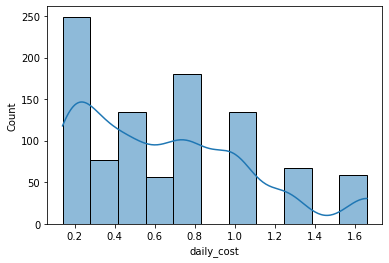

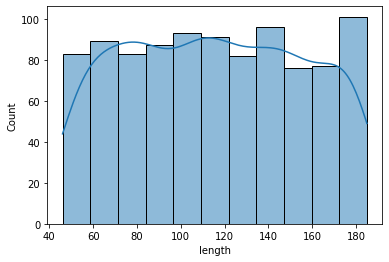

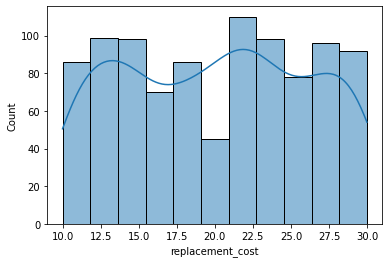

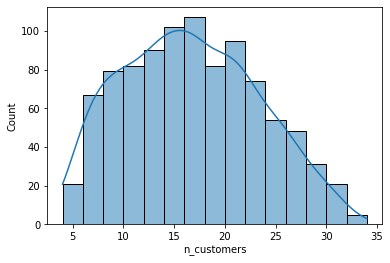

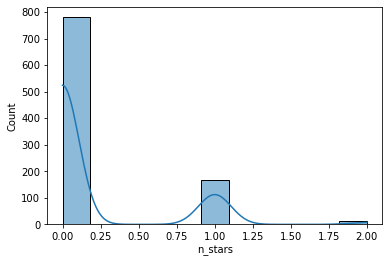

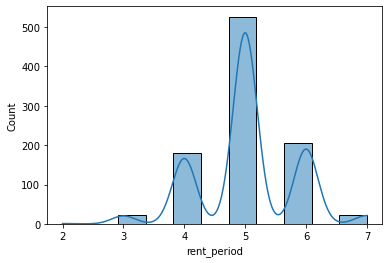

In [79]:
for f in numerical_train.columns:
    sns.histplot(film[f], kde=True)
    plt.show()

### Concat

In [ ]:
# X_train = pd.concat

## Transform and Scaling

In [110]:
feat2power = []
feat2scale = []

for f in X_train.columns:
    # print(f)
    # print(X_train[f].dtype)
    # print(X_train[f].isin([0]))
    if X_train[f].isin([0]).sum() > 0:
        feat2scale.append(f)
    else:
        feat2power.append(f)
        
print(feat2power)
print(feat2scale)

['daily_cost', 'length', 'rating', 'replacement_cost', 'n_customers', 'rent_period']
['top_categories', 'n_stars']


In [112]:
X_train_power = X_train[feat2power]
X_test_power = X_test[feat2power]

In [113]:
X_train_scale = X_train[feat2scale]
X_test_scale = X_test[feat2scale]

### Power Transformer

In [116]:
pt = PowerTransformer(standardize = False).fit(X_train_power)
X_train_power_transformed = pt.transform(X_train_power)
X_test_power_transformed = pt.transform(X_test_power)

In [119]:
pt.get_params

<bound method BaseEstimator.get_params of PowerTransformer(standardize=False)>

In [123]:
X_train_power.columns

Index(['daily_cost', 'length', 'rating', 'replacement_cost', 'n_customers',
       'rent_period'],
      dtype='object')

In [124]:
X_train_power_transformed = pd.DataFrame(X_train_power_transformed, columns =X_train_power.columns )
X_test_power_transformed = pd.DataFrame(X_test_power_transformed, columns =X_train_power.columns)

In [132]:
X_train_power_transformed.isna().sum()

daily_cost          0
length              0
rating              0
replacement_cost    0
n_customers         0
rent_period         0
dtype: int64

In [133]:
len(X_train_power_transformed)

766

### Standar Scaler

In [ ]:
#### Combine

In [ ]:
### Reset train_test_split index

In [135]:
X_train_power_transformed.index

RangeIndex(start=0, stop=766, step=1)

In [140]:
X_train_scale.index

Int64Index([338, 588,  62,  79, 651, 193, 181, 294, 262, 200,
            ...
            723,   9, 359, 707, 763, 835, 192, 629, 559, 684],
           dtype='int64', length=766)

In [137]:
X_train_scale.shape

(766, 2)

In [149]:
X_train_scale.reset_index(drop=True, inplace = True)
X_test_scale.reset_index(drop=True, inplace = True)

In [142]:
X_train_scale.index

RangeIndex(start=0, stop=766, step=1)

In [150]:
X_train_transformed = pd.concat([X_train_power_transformed,X_train_scale], axis=1)
X_test_transformed = pd.concat([X_test_power_transformed,X_test_scale], axis=1)

In [151]:
scaler = MinMaxScaler().fit(X_train_transformed)
X_train_scaled = scaler.transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

In [152]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train_transformed.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_train_transformed.columns)

In [146]:
X_train_scaled.isna().sum()

daily_cost          0
length              0
rating              0
replacement_cost    0
n_customers         0
rent_period         0
top_categories      0
n_stars             0
dtype: int64

In [ ]:
# Parió la abuela

In [134]:
# len(X_train_scaled)

920

## Fit the model and predict

In [ ]:
# Fit

In [153]:
classifier = LogisticRegression() # random_state=0) --> multiclass
classifier = classifier.fit(X_train_scaled,y_train)

In [ ]:
# Predict

In [154]:
y_train_predict = classifier.predict(X_train_scaled)
y_test_predict = classifier.predict(X_test_scaled)

# Metrics

## Logistic score - accuracy

In [ ]:
# Train

In [155]:
classifier.score(X_train_scaled, y_train) 

0.9921671018276762

In [ ]:
# Test

In [157]:
classifier.score(X_test_scaled, y_test)  

1.0

## More error metrics

In [162]:
print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_test_predict)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_test_predict)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_test_predict)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_test_predict)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_test_predict)))

The accuracy in the TEST set is: 1.00
The precision in the TEST set is: 0.00
The recall in the TEST set is: 0.00
The F1 in the TEST set is: 0.00
The Kappa in the TEST set is: nan


/Users/albertomengual/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/albertomengual/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  ----------
/Users/albertomengual/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/albertomengual/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this beh

## Confusion matrix train

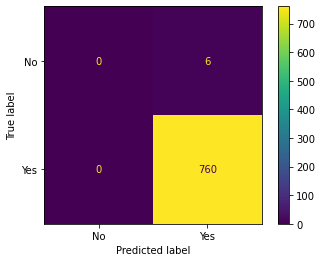

In [164]:
cm_train = confusion_matrix(y_train, y_train_predict)
dispTrain = ConfusionMatrixDisplay(cm_train, display_labels= classifier.classes_)
dispTrain.plot()
plt.show()

In [163]:
classifier.classes_

array(['No', 'Yes'], dtype=object)

## Confusion matrix test

In [165]:
y_test.value_counts()

Yes    192
Name: increase, dtype: int64

In [167]:
y_test_predict #.value_counts()

array(['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes',

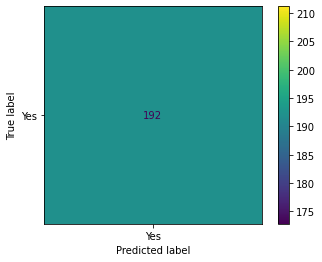

In [170]:
cm_test = confusion_matrix(y_test,y_test_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels= ['Yes'])# classifier.classes_)
disp.plot()
plt.show()